In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator
from pylab import rcParams
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [58]:
# Set figure size
rcParams['figure.figsize'] = (6, 6)

In [3]:
# Set float format
pd.options.display.float_format = "{:,.2f}".format

# Goal
I scraped listings of properties for sale in Cracow. We would like to create a model to predict flat prices.

# Data inspection

Data has been scraped from a website with listings. The data has undergone small transformations along the way. The goal of these transformations was to get the data into a usable state not to check it's validity.

In [4]:
path = '../flats-data/cleaned_data.csv'

In [5]:
data = pd.read_csv(path, lineterminator='\n')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35693 entries, 0 to 35692
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         35600 non-null  object 
 1   City         22682 non-null  object 
 2   District     18446 non-null  object 
 3   Amount       35570 non-null  float64
 4   Currency     35570 non-null  object 
 5   Property     35327 non-null  object 
 6   Seller       35491 non-null  object 
 7   Area         35382 non-null  float64
 8   Rooms        34975 non-null  float64
 9   Bathrooms    22633 non-null  float64
 10  Parking      14734 non-null  object 
 11  Garden       35693 non-null  bool   
 12  Balcony      35693 non-null  bool   
 13  Terrace      35693 non-null  bool   
 14  Lift         35693 non-null  bool   
 15  New          35693 non-null  bool   
 16  Estate       35693 non-null  bool   
 17  Townhouse    35693 non-null  bool   
 18  Apartment    35693 non-null  bool   
 19  Land

Next we inspect numeric features.

In [7]:
data.describe()

,Amount,Area,Rooms,Bathrooms
count,"35,570.00","35,382.00","34,975.00","22,633.00"
mean,"731,287.01",99.97,3.01,1.36
std,"859,314.61","1,929.00",1.32,0.67
min,1.00,1.00,1.00,1.00
25%,"409,000.00",45.00,2.00,1.00
50%,"525,000.00",59.00,3.00,1.00
75%,"760,000.00",87.00,4.00,2.00
max,"22,000,000.00","320,000.00",6.00,4.00


We see that we have 24 columns at our disposal. 
We inspect the numeric columns to see what we are dealing with. 
In the `Amount` column we note there is a property for sale that costs 1PLN, clearly a erroneous value. 
Next we note that the enourmous maximum in the `Amount` column. That is quite a lot of money and could be considered a potential outlier.
The maximum and minimum of the `Area` column also indicate the existance of outliers. These values are clearly too large for flats. The data will need to undergo a filtering process.

We inspect categorical columns to assert that they contain "valid" values. Most of these columns were generated by a script during the scraping and etl phase of the project.

In [8]:
cols_to_check = data.select_dtypes('object').columns
cols_to_check = cols_to_check.to_list()
cols_to_check.remove('Title')
cols_to_check.remove('Link')
cols_to_check.remove('Description')
cols_to_check.remove('Date')

for col in cols_to_check:
    unique = data[col].unique()
    print(f'{col}:')    
    for value in unique:
        print(f'\t{value}')        

City:
	kraków
	nan
District:
	nan
	podgórze
	dębniki
	prądnik biały
	krowodrza
	bieżanów
	stare miasto
	mistrzejowice
	grzegórzki
	bronowice
	nowa huta
	łagiewniki
	zwierzyniec
	czyżyny
	podgórze duchackie
	prądnik czerwony
	swoszowice
	prokocim
	wzgórza krzesławickie
	bieńczyce
	borek fałęcki
Currency:
	pln
	nan
Property:
	flat
	house
	nan
Seller:
	realtor
	owner
	nan
Parking:
	nan
	unknown
	street
	garage
	covered


# Data preparation
## Dealing with NaN's.

First we assume that if the `City` is missing but we have a `District` value the property is in Cracow.

In [9]:
mask = (data['City'].isna() == True) & (data['District'].isna() == False)
data.loc[mask, 'City'] = 'kraków'

We convert binary features to zeroes and ones.

In [10]:
data = data.replace(True, 1)
data = data.replace(False, 0)

We add an extra category `unknown` to the `Parking` and `District` column.

In [11]:
data.loc[:, 'Parking'] = data['Parking'].apply(lambda x: 'unknown' if pd.isnull(x) else x)
data.loc[:, 'District'] = data['District'].apply(lambda x: 'unknown' if pd.isnull(x) else x)

Since there are duplicate rows we assume that each listing has a unique `Title`.

In [12]:
data = data.drop_duplicates(['Title'])

## Filter data
Next we filter the data according to these rules:
1. `Seller` is not `NaN`
2. `Property` is not `NaN`
3. `City` is '`kraków'`
4. `Currency` is Polish Złoty (`PLN`)
5. 50 000 <= `Amount` <= 1 500 000
6. 0 < `Area` <= 200
6. `District` is not `NaN`
7. `Property` is not a `house`

Before applying these filters the shape of the data is:

In [13]:
print(data.shape)

(6862, 24)


In [14]:
data = data[data['Seller'].isna() == False]
data = data[data['Property'].isna() == False]
data = data[data['City'] == 'kraków']
data = data[data['Currency'] == 'pln']
data = data[data['Amount'] >= 5 * 10 ** 4]
data = data[data['Amount'] <= 1.5 * 10 ** 6]
data = data[data['Area'] > 0]
data = data[data['Area'] <= 200]
data = data[data['District'] != 'unknown']
data = data[data['Property'] != 'house']
data = data.reset_index(drop=True)

The shape of the filtered data is:

In [15]:
print(data.shape)

(3431, 24)


## Impute numerical values
The next step is to fill in missing values for numeric columns `Amount` `Area` `Rooms` and `Bathrooms`.

In [16]:
mask = (data['Bathrooms'].isna() == True | data['Rooms'].isna())
to_impute = ['Amount', 'Area', 'Rooms', 'Bathrooms']

missing = data[to_impute]

We use the KNN algorithm to accomplish this.

In [17]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(missing)
missing = imputer.transform(missing)
missing = pd.DataFrame(missing, columns=to_impute)

We add the imputed back into the original dataset.

In [18]:
for col in to_impute:
    data[col] = missing[col]
    
for col in to_impute:
    data[col] = data[col].apply(lambda x: round(x))    

The shape of the data is:

In [19]:
print(data.shape)

(3431, 24)


## Remove columns
The data has been fully processed so we remove the unwanted columns.

In [20]:
data = data.reset_index(drop=True)
data = data.drop(['Title', 
                  'Description', 
                  'Link', 
                  'Property', 
                  'City', 
                  'Currency', 
                  'Date', 
                  'Amount Z-score', 
                  'Area Z-score'], 
                 axis=1, errors='ignore')

data = data.dropna()

The shape of the data is:

In [21]:
print(data.shape)

(3431, 17)


# Feature engineering
The next step is to engineer features. We add columns describing the `Total Rooms` in the property, ratio of `Area to Rooms` and so on.

In [22]:
data['Log Area'] = np.round(np.log(data['Area']), 2)
data['Bool Sum'] = data.select_dtypes(bool).sum(axis=1)
# Avoid division by zero
data['Area to Bool Sum'] = round(data['Area'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bool Sum'] = round(data['Rooms'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bathrooms' ] = round(data['Rooms'] / data['Bathrooms'], 2)
data['Total Rooms'] = round(data['Rooms'] + data['Bathrooms'], 2)
data['Area to Rooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Bathrooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Total Rooms'] = round(data['Area'] / data['Total Rooms'], 2)

# Model

At this stage we are ready to create a test-train split and a pipeline.

## Test-train split
We decide to use 80% of the data to train the model and 20% to check performance.
We make sure to remove the `Amount` column from the training data since this is our target.

In [23]:
X = data.drop(['Amount'], axis=1)
y = data['Amount']

split = train_test_split(X, y, train_size=.8,
                               random_state=123)

X_train, X_test, y_train, y_test = split

The shape of the training data is:

In [24]:
print(X_train.shape, y_train.shape)

(2744, 25) (2744,)


The shape of the testing data is:

In [25]:
print(X_test.shape, y_test.shape)

(687, 25) (687,)


## One Hot Encoding

We apply one hot encoding to categorical features and use the `ColumnTransformer` parameter `passthrough` to allow the rest of the columns to remain unchanged.

In [26]:
categorical_features = ['District', 
                        'Seller', 
                        'Parking']

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

## Models

For model evaulation purposes we create two models: 
1. `DummyRegressor` - we willuse this as the baseline.
2. `GradientBoostingRegressor`.

It would nice if the `GradientBoostingRegressor` outperforms the `DummyRegressor` since it uses averages to make predictions.

In [27]:
reg = GradientBoostingRegressor(random_state=123)
reg_dummy = DummyRegressor()

## Pipeline

For each model we create a seperate pipeline.

In [28]:
mdl = Pipeline(steps = [('preprocessor', preprocessor),
                        ('regressor', reg)])

dum = Pipeline(steps = [('preprocessor', preprocessor),
                        ('regressor', reg_dummy)])

## Parameter Tuning
We create a parameter grid to conduct basic parameter tuning and perfom cross-validation.

In [29]:
param_grid = {"regressor__max_depth": [3], 
              "regressor__n_estimators": [100],
              "regressor__min_samples_split": [2],
              "regressor__min_samples_leaf": [2],
              "regressor__max_features": ['auto']}

gs = GridSearchCV(estimator=mdl, 
                  param_grid=param_grid,
                  cv=2,
                  n_jobs=8,
                  verbose=2)

We then fit the model to the data.

In [31]:
gs.fit(X_train, y_train)
mdl = gs.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.0s finished


We then fit the dummy model to the data.

In [33]:
dum.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['District', 'Seller',
                                                   'Parking'])])),
                ('regressor', DummyRegressor())])

## Performance evaluation
### Metrics

We obtain predictions for the testing set.

In [48]:
y_pred_dum = dum.predict(X_test)
y_pred = mdl.predict(X_test)

We compare `RMSE`, `MAE` and `MSLE` for our models. The scores of the dummy model are:

In [49]:
dum_rmse = mean_squared_error(y_pred=y_pred_dum, y_true=y_test, squared=False)
dum_mae = mean_absolute_error(y_pred=y_pred_dum, y_true=y_test)
dum_msle = mean_squared_log_error(y_pred=y_pred_dum, y_true=y_test)

print(f'Dummy model:')
print(f'RMSE: {dum_rmse:10.2f}')
print(f'MAE:  {dum_mae:10.2f}')
print(f'MSLE: {dum_msle:10.2f}')

Dummy model:
RMSE:  230260.40
MAE:   172417.13
MSLE:       0.18


The scores of the actual model are:

In [50]:
rmse = mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
msle = mean_squared_log_error(y_pred=y_pred, y_true=y_test)

print('Actual model')
print(f'RMSE: {rmse:10.2f}')
print(f'MAE:  {mae:10.2f}')
print(f'MSLE: {msle:10.2f}')

Actual model
RMSE:  115096.87
MAE:    77954.81
MSLE:       0.04


### Performance comparison

We are happy to see that the `GradientBoostingRegressor` outperfomed the `DummyRegressor` significantly.
In terms of percentages the improvements are:

In [52]:
scores = [[dum_rmse, dum_mae, dum_msle],
          [rmse, mae, msle]]

scores = pd.DataFrame(scores, 
                      index=['Dummy', 'Model'], 
                      columns=['MSE', 'MAE', 'MSLE'])

scores = scores.transpose()
scores['Improvement (%)'] = np.round((scores['Model'] / scores['Dummy'] - 1) * 100, 2)

scores

,Dummy,Model,Improvement (%)
MSE,"230,260.40","115,096.87",-50.01
MAE,"172,417.13","77,954.81",-54.79
MSLE,0.18,0.04,-75.50


Our model after parameter tuning is:

In [53]:
mdl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['District', 'Seller',
                                                   'Parking'])])),
                ('regressor',
                 GradientBoostingRegressor(max_features='auto',
                                           min_samples_leaf=2,
                                           random_state=123))])

### Visuals
We produce a couple of plots the visually inspect the performance of our model.
We use the test data set with the predicted `Amount` to produce the plots.

In [54]:
cols = ['Amount', 'Predicted Amount', 
        'District', 'Area', 'Total Rooms']

X_pred = X_test.copy()
X_pred.loc[:, 'Amount'] = y
X_pred.loc[:, 'Predicted Amount'] = y_pred
X_pred = X_pred.loc[:, cols]

X_pred.head()

,Amount,Predicted Amount,District,Area,Total Rooms
3117,991000,"820,214.01",podgórze,90,3
646,369000,"381,753.23",nowa huta,47,3
776,1000000,"726,125.56",prądnik czerwony,166,8
2306,1199000,"1,114,750.76",stare miasto,102,4
956,594000,"859,928.53",stare miasto,65,3


On our first visual it can be seen that there exists a fairly linear relationship between the `Predicted Amount` and the `Area` of the property.

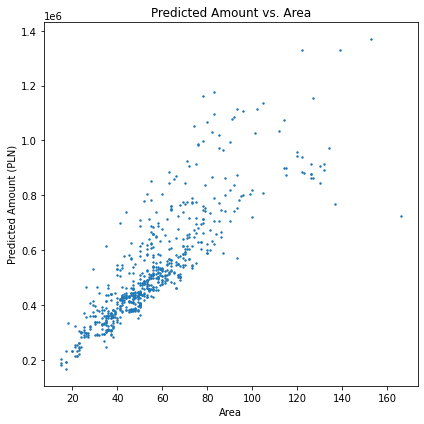

In [59]:
plt.scatter(X_pred['Area'], X_pred['Predicted Amount'], s=2)
plt.title('Predicted Amount vs. Area')
plt.xlabel('Area')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

On the second visual it can bee seen, as expected the more `Total Rooms` in a `Property` the more it should cost.

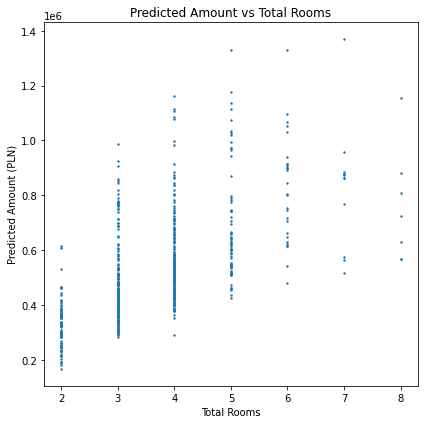

In [60]:
plt.scatter(X_pred['Total Rooms'], X_pred['Predicted Amount'], s=2)
plt.title('Predicted Amount vs Total Rooms')
plt.xlabel('Total Rooms')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Next we want to check if the model distinguishes between districts. We group the data by `District` and calculate the mean of the predictions with the group. We produce a bar chart sorted from highest average to lowest. Clearly the model distinguishes between district that are near the city center (`stare miasto`, `zwierzyniec`) and those further away (`łagiewniki`, `bieżanów`).

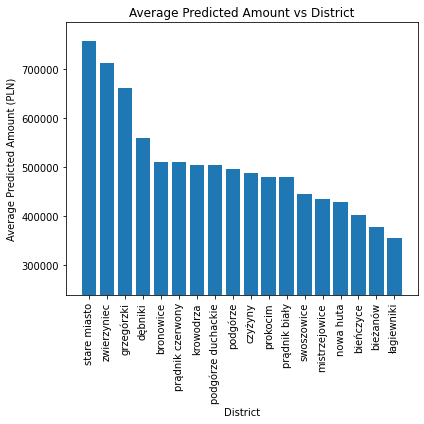

In [61]:
X_grp = X_pred[['District', 'Predicted Amount']]
X_grp = X_grp.groupby('District', as_index=False).mean()
X_grp = X_grp.sort_values('Predicted Amount', ascending=False)

plt.figure()

plt.bar(X_grp['District'], X_grp['Predicted Amount'])

plt.title('Average Predicted Amount vs District')
plt.xlabel('District')
plt.ylabel('Average Predicted Amount (PLN)')
plt.ylim(X_grp['Predicted Amount'].min() * 0.67, None)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### Model vs. arbitrary inputs
Next we would like see how the model handles sets of arbitrary parameters. We write a function to transform inputs to desired format and obtain prediction from the model.

In [63]:
def get_pred(district,
             seller,
             area,
             rooms,
             bathrooms,
             parking,
             garden,
             balcony,
             terrace,
             lift,
             new,
             estate,
             townhouse,
             apartment,
             land,
             studio):

    columns = ['District',
               'Seller',
               'Area',
               'Rooms',
               'Bathrooms',
               'Parking',
               'Garden',
               'Balcony',
               'Terrace',
               'Lift',
               'New',
               'Estate',
               'Townhouse',
               'Apartment',
               'Land',
               'Studio',
               'Log Area',
               'Bool Sum',
               'Area to Bool Sum',
               'Rooms to Bool Sum',
               'Rooms to Bathrooms',
               'Total Rooms',
               'Area to Rooms',
               'Area to Bathrooms',
               'Area to Total Rooms']
        
    log_area = np.log(area)

    all_bools = [garden,
                 balcony,
                 terrace,
                 lift,
                 new,
                 estate,
                 townhouse,
                 apartment,
                 land,
                 studio]
    
    bool_sum = sum(all_bools)
    area_to_bool_sum = area / (bool_sum + 1)
    rooms_to_bool_sum = rooms / (bool_sum + 1)    
    rooms_to_bathrooms = rooms / bathrooms        
    total_rooms = rooms + bathrooms
    area_to_rooms = area / total_rooms
    area_to_bathrooms = area / bathrooms
    area_to_total_rooms = area / total_rooms
    
    x = [district,
         seller,
         area,
         rooms,
         bathrooms,
         parking,
         garden,
         balcony,
         terrace,
         lift,
         new,
         estate,
         townhouse,
         apartment,
         land,
         studio,
         log_area,
         bool_sum,
         area_to_bool_sum,
         rooms_to_bool_sum,
         rooms_to_bathrooms,
         total_rooms,
         area_to_rooms,
         area_to_bathrooms,
         area_to_total_rooms]    
    
    x = pd.DataFrame([x], columns=columns)    
    x = float(mdl.predict(x))

    return int(round(x, -3))    

We create lists of inputs for the model to predict.

In [ ]:
areas = range(30, 120, 5)
rooms = range(1, 5)
districts = ['stare miasto', 
             'bronowice', 
             'podgórze', 
             'krowodrza']

Next we loop over lists of possible areas and rooms and plot the outputs. First we check how the model reacts to different districts.

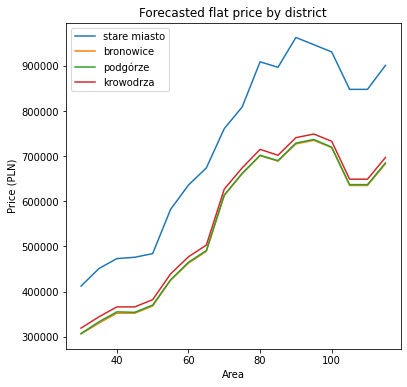

In [64]:
plt.figure()

for d in districts:
    value = list()
    for a in areas:
        pred = get_pred(district=d,
         seller='realtor',
         area=a,
         rooms=2,
         bathrooms=1,
         parking='street',
         garden=False,
         balcony=False,
         terrace=False,
         lift=False,
         new=True,
         estate=False,
         townhouse=True,
         apartment=False,
         land=False,
         studio=True)
        value.append(pred)
    plt.plot(areas, value, label=d)
    
plt.title('Forecasted flat price by district')
plt.ylabel('Price (PLN)')
plt.xlabel('Area')
plt.legend(loc='best')
plt.show()

We do the same for different amounts of rooms.

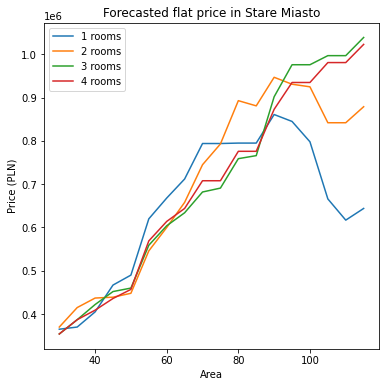

In [65]:
plt.figure()

for r in rooms:
    value = list()
    for a in areas:
        pred = get_pred(district='stare miasto',
         seller='owner',
         area=a,
         rooms=r,
         bathrooms=1,
         parking='street',
         garden=False,
         balcony=True,
         terrace=False,
         lift=False,
         new=True,
         estate=False,
         townhouse=True,
         apartment=False,
         land=False,
         studio=True)
        value.append(pred)
    plt.plot(areas, value, label=f'{r} rooms')
    
plt.title('Forecasted flat price in Stare Miasto')
plt.ylabel('Price (PLN)')
plt.xlabel('Area')    
plt.legend(loc='best')
plt.show()

# Fit final model

The last step is to fit the model to the entire dataset and save it for later use.

In [ ]:
mdl.fit(X, y)
model_path = '../flats-model'
joblib.dump(mdl, f'{model_path}/model.joblib')